In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_json('/content/drive/My Drive/Dicoding/Belajar Pengembangan Machine Learning/News_Category_Dataset_v2.json', lines=True)


df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
df.shape

(200853, 6)

In [ ]:
len(df.category.unique())

41

There are 41 categories in this data. And i think it is too many for me as a beginner. So, I only take 5 categories for this submission. (POLITICS, FOOD & DRINK, BUSINESS, HOME & LIVING, TRAVEL)

In [ ]:
df_first = df.loc[(df['category'] == 'POLITICS') | (df['category'] == 'FOOD & DRINK') | (df['category'] == 'BUSINESS') | (df['category'] == 'HOME & LIVING') | (df['category'] == 'TRAVEL')]

Delete some columns 

In [ ]:
df_second = df_first.drop(columns=['authors', 'link', 'date'])

Dataframe dimension

In [ ]:
df_second.shape

(58984, 3)

Now, the data only contains 58984 rows.

Import libraries

In [ ]:
from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import nltk, os, re, string
from nltk.corpus import stopwords

# nltk.download() #wordnet stopwords

Clean the data

In [ ]:
# LOWER CASE ALL CHARACTERS 
df_second.headline = df_second.headline.apply(lambda x: x.lower())
df_second.short_description = df_second.short_description.apply(lambda x: x.lower())

## LEMMATIZATION
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
lemmatizer = WordNetLemmatizer()

def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

df_second.headline = df_second.headline.apply(lambda x: lem(x))
df_second.short_description = df_second.short_description.apply(lambda x: lem(x))

# REMOVING PUNCTUATION
def cleaner(text):
    return(text.translate(str.maketrans('','', string.punctuation)))
df_second.headline = df_second.headline.apply(lambda x: cleaner(x))
df_second.short_description = df_second.short_description.apply(lambda x: lem(x))

# REMOVING NUMBERS
def rem_numbers(text):
    return re.sub('[0-9]+','',text)
df_second['headline'].apply(rem_numbers)
df_second['short_description'].apply(rem_numbers)

# REMOVING STOPWORDS
st_words = stopwords.words()
def stopword(text):
    return(' '.join([w for w in text.split() if w not in st_words ]))
df_second.headline = df_second.headline.apply(lambda x: stopword(x))
df_second.short_description = df_second.short_description.apply(lambda x: lem(x))

In [ ]:
df_second.head()

,category,headline,short_description
13,POLITICS,trumps crackdown immigrant parent put kid alre...,last month a health and human service official...
14,POLITICS,trumps concerned fbi obtained wiretap putin al...,the wiretap feature conversation between alexa...
15,POLITICS,edward snowden theres trump love vladimir putin,"but don't count on robert mueller to nail him,..."
16,POLITICS,booyah obama photographer hilariously troll tr...,just a peeping minute.
17,POLITICS,ireland vote repeal abortion amendment landsli...,irish woman will no longer have to travel to t...


Apply one hot encoding to the data.

In [ ]:
category = pd.get_dummies(df_second.category)
df_third = pd.concat([df_second, category], axis=1)
df_third = df_third.drop(columns='category')
df_third

,headline,short_description,BUSINESS,FOOD & DRINK,HOME & LIVING,POLITICS,TRAVEL
13,trumps crackdown immigrant parent put kid alre...,last month a health and human service official...,0,0,0,1,0
14,trumps concerned fbi obtained wiretap putin al...,the wiretap feature conversation between alexa...,0,0,0,1,0
15,edward snowden theres trump love vladimir putin,"but don't count on robert mueller to nail him,...",0,0,0,1,0
16,booyah obama photographer hilariously troll tr...,just a peeping minute.,0,0,0,1,0
17,ireland vote repeal abortion amendment landsli...,irish woman will no longer have to travel to t...,0,0,0,1,0
...,...,...,...,...,...,...,...
200833,four bank closure mark week january 27 2012,the general pattern of the fdic closing bank w...,1,0,0,0,0
200834,everything need know overdraft fee graphic,don't like keeping all of your money stuffed u...,1,0,0,0,0
200835,walmart waving goodbye greeter,"after 30 years, ""people greeters"" will no long...",1,0,0,0,0
200836,world economic forum fear global contagion dom...,"for decades, a crisis have assailed developing...",1,0,0,0,0


concantenate headlines column with each short_description into headline dataframe. Put the labels in label dataframe. 

In [ ]:
headline = df_third['short_description'].values + ' ' + df_third['headline'].values
label = df_third[['FOOD & DRINK', 'HOME & LIVING', 'POLITICS', 'BUSINESS', 'TRAVEL']].values

In [ ]:
headline

array(['last month a health and human service official revealed the government wa unable to locate nearly 1,500 child who had been released from it custody. trumps crackdown immigrant parent put kid already strained system',
       'the wiretap feature conversation between alexander torshin and alexander romanov, a convicted russian money launderer. trumps concerned fbi obtained wiretap putin ally trump jr',
       "but don't count on robert mueller to nail him, the nsa whistleblower warns. edward snowden theres trump love vladimir putin",
       ...,
       'after 30 years, "people greeters" will no longer welcome walmart customer with a "cart and a smile." four month after walmart walmart waving goodbye greeter',
       'for decades, a crisis have assailed developing country from indonesia to argentina, the powers-that-be in the united state world economic forum fear global contagion dominates',
       '"analysts at adobe combined historical purchase and upgrade data with survey data

Split data into training and validation 

In [ ]:
from sklearn.model_selection import train_test_split
headline_train, headline_test, label_train, label_test = train_test_split(headline, label, test_size=0.2, shuffle=True)

Process each words into token using tokenize function from Keras.

In [ ]:
max_len = 256

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(lower=True, char_level=False)
tokenizer.fit_on_texts(headline_train) 
tokenizer.fit_on_texts(headline_test)
	 
sekuens_train = tokenizer.texts_to_sequences(headline_train)
sekuens_test = tokenizer.texts_to_sequences(headline_test)
	 
padded_train = pad_sequences(sekuens_train, padding='post', maxlen=max_len) 
padded_test = pad_sequences(sekuens_test, padding='post', maxlen=max_len)

word_to_index = tokenizer.word_index

Use GloVe learning algorithm for obtaining vector representations for words devolped by Stanford

In [ ]:
vocab_size =  len(word_to_index)
oov_tok = "<OOV>"
embedding_dim = 200

In [ ]:
import numpy as np
embeddings_index = {};

# !unzip '/content/drive/My Drive/Dicoding/Belajar Pengembangan Machine Learning/1835_3176_compressed_glove.6B.200d.txt.zip'

with open('/content/glove.6B.200d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

Design the model.

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], trainable=False, input_length = max_len),
    tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout1D(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
# model = modeling()
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss= 'categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 200)          10858000  
_________________________________________________________________
bidirectional (Bidirectional (None, 256, 512)          935936    
_________________________________________________________________
dropout (Dropout)            (None, 256, 512)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 512)          2048      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 512)          0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

Train the model.

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

num_epochs = 20
history = model.fit(padded_train, label_train, epochs=num_epochs, 
	                    validation_data=(padded_test, label_test), verbose=2, callbacks=[es])

Epoch 1/20
1475/1475 - 247s - loss: 0.5508 - accuracy: 0.8197 - val_loss: 0.3463 - val_accuracy: 0.8840
Epoch 2/20
1475/1475 - 246s - loss: 0.3672 - accuracy: 0.8854 - val_loss: 0.3160 - val_accuracy: 0.8952
Epoch 3/20
1475/1475 - 246s - loss: 0.3216 - accuracy: 0.9014 - val_loss: 0.2779 - val_accuracy: 0.9058
Epoch 4/20
1475/1475 - 246s - loss: 0.3089 - accuracy: 0.9056 - val_loss: 0.2809 - val_accuracy: 0.9071
Epoch 5/20
1475/1475 - 245s - loss: 0.2508 - accuracy: 0.9238 - val_loss: 0.2978 - val_accuracy: 0.9099
Epoch 6/20
1475/1475 - 245s - loss: 0.2185 - accuracy: 0.9352 - val_loss: 0.2946 - val_accuracy: 0.9135
Epoch 7/20
1475/1475 - 247s - loss: 0.1813 - accuracy: 0.9478 - val_loss: 0.2965 - val_accuracy: 0.9122
Epoch 8/20
1475/1475 - 248s - loss: 0.1498 - accuracy: 0.9559 - val_loss: 0.3636 - val_accuracy: 0.9062


As you can see, we got validation accuracy about 90%. Next, plot the accuracy and loss. 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


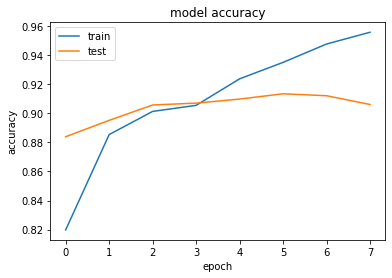

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

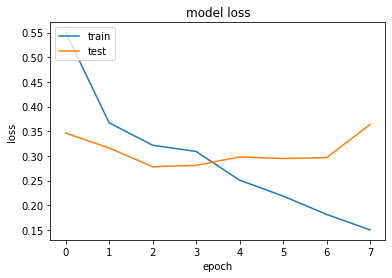

In [ ]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()